In [1]:
import numpy as np
from scipy import optimize
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import sklearn as sk

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import utility_functions as fn

# Initialization

In [2]:
# read from csv into a new dataframe
raw_weather = pd.read_csv('weather_raw2.csv',index_col=1)

# reindex by appropriate datetime
raw_weather.index = pd.to_datetime(raw_weather.index,format='%Y-%m-%d %H:00:00 +0000 UTC')
raw_weather.index.names = ['']

# remove unused columns
raw_weather.drop(raw_weather.columns[np.array([0,1,2,3,4,9,10,13,15,16,17,19,20,21,23,24,25,26])],axis=1,inplace=True)

# rename and reorder columns
column_names = ['temp','tmin','tmax','pressure','humidity','wind','rain','snow','clouds']
raw_weather.columns = column_names
raw_weather = raw_weather[['temp','tmin','tmax','pressure','humidity','wind','clouds','rain','snow']]

In [3]:
# drop duplicate rows
raw_weather.drop_duplicates(inplace=True)

# reindex to add missing rows, for a total length of 53545
correct_dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')
raw_weather = raw_weather.reindex(index=correct_dt)

In [4]:
print(raw_weather.isnull().sum())
# fn.plot_all(raw_weather,'2013-01-02 00:00:00','2019-02-09 00:00:00')

temp         1129
tmin         1129
tmax         1129
pressure     1129
humidity     1129
wind         1129
clouds       1129
rain        49699
snow        53440
dtype: int64


# Error Identification

In [5]:
# set violating values to NaN based on hardcoded low and high limit values for each column separately
sparse_weather = raw_weather.copy(deep=True)

low_tuners = [250,240,250,900,5,0,0,0,0]
high_tuners = [350,350,350,1100,100,25,100,100,10]
j=0

for i in raw_weather.columns:
    sparse_weather[i].where(sparse_weather[i] >= low_tuners[j],inplace=True)
    sparse_weather[i].where(sparse_weather[i] <= high_tuners[j],inplace=True)
    j=j+1

In [6]:
# assign NaN precip values to zero, this is an unconfirmed assumption
sparse_weather['rain'].replace(np.NaN,0,inplace=True)
sparse_weather['snow'].replace(np.NaN,0,inplace=True)

# set initial humidity value to suppress errors
sparse_weather['humidity'][0] = 46

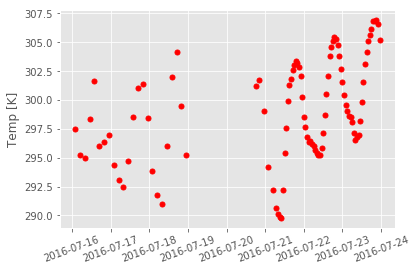

In [7]:
# fn.plot_all(sparse_weather,'2013-01-01 00:00:00','2019-02-10 00:00:00')
fn.plot_feature(sparse_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')
# print(sparse_weather.isnull().sum())

# Imputation

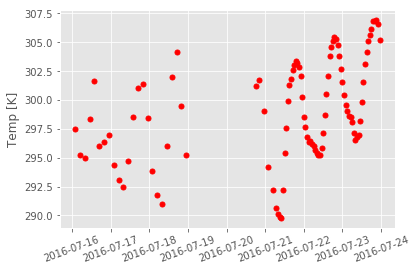

temp        1136
tmin        1136
tmax        1136
pressure    1521
humidity    2160
wind        1133
clouds      1129
rain           0
snow           0
dtype: int64


In [17]:
# impute missing ranges shorter than 6 hours using linear interpolation
dense_weather = sparse_weather.copy(deep=True)

# create a df w/ same shape as dense_weather where NaN ranges longer than 6 hours are marked False
# TO BE IMPROVED, the performance of this function is currently very bad
# bool_gaps = fn.gap_finder(dense_weather,6)

fn.plot_feature(dense_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')
print(dense_weather.isnull().sum())

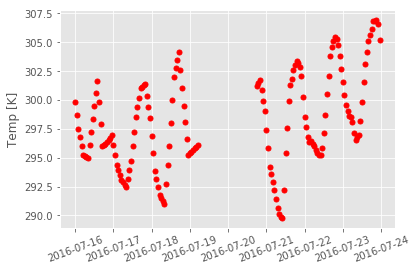

temp         96
tmin         96
tmax         96
pressure    100
humidity    222
wind        104
clouds       96
rain          0
snow          0
dtype: int64


In [18]:
# # interpolates gaps shorter than 6 hours as indicated by bool_gaps
# for i in dense_weather.columns:
#     bool_gaps = fn.gap_finder(dense_weather,i,6)
#     dense_weather[i].mask(bool_gaps[i]==True,dense_weather[i].interpolate(method='linear'),inplace=True)
    
# workaround, uses linear impute for gaps with a 6 hour limit
dense_weather.interpolate(method='linear',limit=6,inplace=True)

fn.plot_feature(dense_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')
print(dense_weather.isnull().sum())

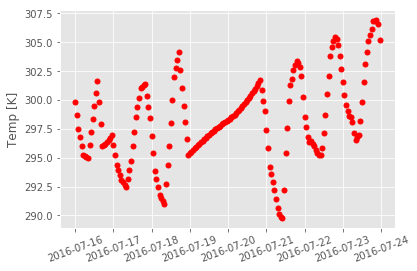

temp        0
tmin        0
tmax        0
pressure    0
humidity    0
wind        0
clouds      0
rain        0
snow        0
dtype: int64

In [19]:
# implement sine_impute function, currently very broken due to gap_finder issues
# for i in range(len(dense_weather.columns)):
#     dense_weather = fn.sine_impute(dense_weather,i)

# workaround, impute values using quadratic fit which works well for gaps less than 24 hours
dense_weather.interpolate(method='quadratic',inplace=True)

fn.plot_feature(dense_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')
dense_weather.isnull().sum()

# Additional Features & Scaling

In [ ]:
# # this function adds columns with data from previous hours associated with the target hour
# hours_before = np.arange(16,25)
# weather_with_previous = fn.add_hours_before(dense_weather,hours_before)
# weather_with_previous.describe()

In [ ]:
# # implements sklearn MinMaxScaler
# x = weather_with_previous.values
# scaler = sk.preprocessing.MinMaxScaler(feature_range=(0, 1))
# x_scaled = scaler.fit_transform(x)

# scaled = pd.DataFrame(x_scaled)
# scaled.columns = weather_with_previous.columns
# scaled.index = weather_with_previous.index

# scaled.describe()

# Export

In [20]:
dense_weather.to_csv('weather_clean.csv')

# unused code below

In [ ]:
# # returns index labels where nan values appear for a certain column
# nan_index = weather['temp'].index[weather['temp'].apply(np.isnan)]
# nan_index

# correct and complete datetime index for the date range considered
# dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')

# # renames (here, makes lowercase) column labels using a simple loop
# df.columns = [x.lower() for x in df.columns]

# # implements sklearn scaler
# from sklearn import preprocessing
# x = df.values #returns a numpy array
# scaler = preprocessing.MinMaxScaler()
# x_scaled = scaler.fit_transform(x)
# df = pandas.DataFrame(x_scaled)

In [ ]:
# code from when i was adding an 'impute_ok' column

# TEMPORARY bypass missing 2014-2015 data
# weather = raw_weather.truncate('2016-01-01 00:00:00','2019-02-10 00:00:00')
# weather = raw_weather.copy(deep=False)

# add an 'impute_ok' column; True if time gap is less than 6 hours
# orig_len = len(raw_weather.index)
# raw_weather.insert(0,'impute_ok',True)
# raw_weather['impute_ok'].iloc[1:orig_len]=(raw_weather.index[1:orig_len]-raw_weather.index[0:orig_len-1] <= '06:00:00')

In [ ]:
# COULD BE USEFUL, first implementation of fit_sin that worked pretty well

# # assigning gap indices manually for now, use impute_ok later on
# gap_start = dense_weather.index.get_loc('2016-07-19 00:00:00')
# gap_end = dense_weather.index.get_loc('2016-07-20 17:00:00')
# gap_length = gap_end - gap_start

# # could calculate this as gap_start - (gap_length*2,3)
# impute_start = dense_weather.index.get_loc('2016-07-10 00:00:00')

# # subset dense_weather to the values just before the gap
# impute_data = dense_weather.iloc[impute_start:gap_start]
# impute_data.index = np.arange(len(impute_data))

# fit = fn.fit_sin(impute_data.index,impute_data['temp'])

# dense_weather.iloc[gap_start:gap_end,[0]] = pd.DataFrame(fit['fitfunc'](np.arange(len(impute_data),len(impute_data)+gap_length,1))).values

# fn.plot_feature(dense_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')

# impute_data['temp'].values
# impute_data.iloc[:,[0]].T.values


In [ ]:
# FIRST PASS at writing sine_impute function, more updated version in utility_functions.py
# use fn.gaps_as_df AND fn.sine_fit to sine fit one column

# df_in = dense_weather.copy(deep=True)
# k = 0

# df_out = df_in.copy(deep=True)
# gaps = fn.gaps_as_df(bool_gaps,)



# for k in range(len(df_in.columns)):
    
# def sine_impute(df_in,column):
#     """
#     Imputes all gaps in data using a least-squares optimized sinusoidal fit function
    
#     df_in: DataFrame to which the target column belongs
#     column: str name of column to be imputed
#     """
#     df_out = df_in.copy(deep=True)
#     gaps = fn.gaps(df_in,column,6)

#     for i in gaps.index:

#         data_start_index = gaps.start[i] - 2*gaps.length[i]-1
#         data_end_index = gaps.start[i]-1
#         impute_start_index = gaps.start[i]
#         impute_end_index = gaps.end[i]

#         # print(gaps.start[i])
#         # print(gaps.end[i])

#         x_start = 0
#         x_end = data_end_index - data_start_index
#         x_impute_start = x_end+1
#         x_impute_end = impute_end_index - data_start_index

#         sine_fit = fn.sine_fit(df_in,df_in.columns[k],data_start_index,data_end_index)

#         imputed_values = sine_fit['fit'](np.arange(x_impute_start,x_impute_end))

#         # print(imputed_values)

#         df_in.iloc[gaps.start[i]:gaps.end[i],[k]] = pd.DataFrame(imputed_values).values
        
#     return df_out
